<a href="https://colab.research.google.com/github/anirud25/TwitterSentimentAnalysis/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Exploratory Data Analysis

In [33]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget https://archive.apache.org/dist/hadoop/common/hadoop-3.3.1/hadoop-3.3.1.tar.gz
# !tar -xzf hadoop-3.3.1.tar.gz
# !wget https://archive.apache.org/dist/pig/pig-0.17.0/pig-0.17.0.tar.gz
# !tar -xzf pig-0.17.0.tar.gz
# !wget https://archive.apache.org/dist/hive/hive-3.1.2/apache-hive-3.1.2-bin.tar.gz
# !tar -xzf apache-hive-3.1.2-bin.tar.gz
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
spark = SparkSession.builder \
    .appName("PigHivePySparkApp") \
    .config("spark.sql.warehouse.dir", "/user/hive/warehouse") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .enableHiveSupport() \
    .getOrCreate()

# Load the dataset into Hive
tweets_df = spark.read.csv("/content/drive/MyDrive/Courses/Sem 2/Big data /Tweet.csv", header=True, inferSchema=True)
tweets_df.write.mode("overwrite").saveAsTable("company_tweets")

In [4]:
company_df = spark.read.csv("/content/drive/MyDrive/Courses/Sem 2/Big data /Company_Tweet.csv", header=True, inferSchema=True)
company_df.write.mode("overwrite").saveAsTable("tweets_symbol")

In [4]:
# Display the schema of the DataFrame
print("DataFrame Schema:")
tweets_df.printSchema()

# Display summary statistics of numerical columns
print("\nSummary Statistics:")
tweets_df.describe().show()

# Count null values in each column
print("\nNull Value Counts:")
null_counts = {}
for column in tweets_df.columns:
    hive_query = f"""
    SELECT SUM(CASE WHEN {column} IS NULL THEN 1 ELSE 0 END) AS {column}
    FROM company_tweets
    """
    result = spark.sql(hive_query).collect()[0]
    null_counts[column] = result[column]
print(null_counts)


DataFrame Schema:
root
 |-- tweet_id: long (nullable = true)
 |-- writer: string (nullable = true)
 |-- post_date: integer (nullable = true)
 |-- body: string (nullable = true)
 |-- comment_num: string (nullable = true)
 |-- retweet_num: string (nullable = true)
 |-- like_num: string (nullable = true)


Summary Statistics:
+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|summary|            tweet_id|              writer|          post_date|                body|         comment_num|         retweet_num|            like_num|
+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|  count|             3717964|             3670691|            3717964|             3717964|             3717811|             3717780|             3717894|
|   mean|8.797443660974791...|1.0945856918732395E9|

#### NULL and Non-Numeric values in columns

In [14]:
from pyspark.sql.functions import col, sum as _sum
#null_counts = tweets_df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in tweets_df.columns])
null_counts.show()

tweets_df.filter(~col("like_num").cast("string").rlike("^\\d+$") | (col("like_num") == "")).show(5)

tweets_df.filter(tweets_df["like_num"].isNull()).show(5)

+--------+------+---------+----+-----------+-----------+--------+
|tweet_id|writer|post_date|body|comment_num|retweet_num|like_num|
+--------+------+---------+----+-----------+-----------+--------+
|       0| 47273|        0|   0|        153|        184|      70|
+--------+------+---------+----+-----------+-----------+--------+

+------------------+--------------+----------+--------------------+--------------+--------------------+--------------------+
|          tweet_id|        writer| post_date|                body|   comment_num|         retweet_num|            like_num|
+------------------+--------------+----------+--------------------+--------------+--------------------+--------------------+
|550704687469453314|     jjen_abel|1420133203|"""Safety used to...| US treasuries| blue-chip stocks...|               $AAPL|
|550824655377158144|    LukasFittl|1420161806|"""Safety used to...| US treasuries| and blue chip st...|               $AAPL|
|551020289308782592|mesutdarendeli|142020844

In [5]:
# Remove rows with null values (equivalent to dropna() in Pandas)
tweets_df.createOrReplaceTempView("temp_tweets")
tweets_df_cleaned = spark.sql("SELECT * FROM temp_tweets WHERE writer IS NOT NULL and comment_num IS NOT NULL and retweet_num IS NOT NULL and like_num IS NOT NULL ")

# Display the number of rows before and after removing null values
print(f"\nNumber of Rows Before Removing Null Values: {tweets_df.count()}")
print(f"Number of Rows After Removing Null Values: {tweets_df_cleaned.count()}")

# Display the first few rows of the cleaned DataFrame
print("\nFirst Few Rows of Cleaned DataFrame:")
tweets_df_cleaned.show(5)


Number of Rows Before Removing Null Values: 3717964
Number of Rows After Removing Null Values: 3670484

First Few Rows of Cleaned DataFrame:
+------------------+---------------+----------+--------------------+-----------+-----------+--------+
|          tweet_id|         writer| post_date|                body|comment_num|retweet_num|like_num|
+------------------+---------------+----------+--------------------+-----------+-----------+--------+
|550441509175443456|VisualStockRSRC|1420070457|lx21 made $10,008...|          0|          0|       1|
|550441672312512512|    KeralaGuy77|1420070496|Insanity of today...|          0|          0|       0|
|550441732014223360|    DozenStocks|1420070510|S&P100 #Stocks Pe...|          0|          0|       0|
|550442977802207232|   ShowDreamCar|1420070807|$GM $TSLA: Volksw...|          0|          0|       1|
|550443807834402816|   i_Know_First|1420071005|Swing Trading: Up...|          0|          0|       1|
+------------------+---------------+------

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

# Define the is_numeric UDF
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Register the UDF with Spark
spark.udf.register("is_numeric", is_numeric, BooleanType())

# Register a temporary view for the cleaned DataFrame
tweets_df_cleaned.createOrReplaceTempView("cleaned_tweets")

# Create a new view with converted numeric columns
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW cleaned_tweets_numeric AS
SELECT
    tweet_id,
    writer,
    post_date,
    body,
    CASE WHEN is_numeric(comment_num) THEN comment_num ELSE 0 END AS comment_num_numeric,
    CASE WHEN is_numeric(retweet_num) THEN retweet_num ELSE 0 END AS retweet_num_numeric,
    CASE WHEN is_numeric(like_num) THEN like_num ELSE 0 END AS like_num_numeric
FROM cleaned_tweets
""")
tweets_df_cleaned = spark.sql("SELECT * FROM cleaned_tweets_numeric limit 10")
tweets_df_cleaned.show(10)

+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+
|          tweet_id|         writer| post_date|                body|comment_num_numeric|retweet_num_numeric|like_num_numeric|
+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+
|550441509175443456|VisualStockRSRC|1420070457|lx21 made $10,008...|                  0|                  0|               1|
|550441672312512512|    KeralaGuy77|1420070496|Insanity of today...|                  0|                  0|               0|
|550441732014223360|    DozenStocks|1420070510|S&P100 #Stocks Pe...|                  0|                  0|               0|
|550442977802207232|   ShowDreamCar|1420070807|$GM $TSLA: Volksw...|                  0|                  0|               1|
|550443807834402816|   i_Know_First|1420071005|Swing Trading: Up...|                  0|                  0|          

##### Join Cleaned Tweets Data and Tweets Symbol

In [7]:
# Join the cleaned_tweets_numeric view with tweets_symbol table
joined_df = spark.sql("""
    SELECT ctn.*, ts.ticker_symbol
    FROM cleaned_tweets_numeric AS ctn
    LEFT JOIN tweets_symbol AS ts
    ON ctn.tweet_id = ts.tweet_id
""")

# Create a new table 'tweets_dataset' from the joined DataFrame
joined_df.write.mode("overwrite").saveAsTable("tweets_dataset")
tweets_dataset = spark.sql("SELECT * FROM tweets_dataset")
tweets_dataset.show(5)

+------------------+--------------+----------+--------------------+-------------------+-------------------+----------------+-------------+
|          tweet_id|        writer| post_date|                body|comment_num_numeric|retweet_num_numeric|like_num_numeric|ticker_symbol|
+------------------+--------------+----------+--------------------+-------------------+-------------------+----------------+-------------+
|550441732014223360|   DozenStocks|1420070510|S&P100 #Stocks Pe...|                  0|                  0|               0|         AMZN|
|550443807834402816|  i_Know_First|1420071005|Swing Trading: Up...|                  0|                  0|               1|         AAPL|
|550443807834402816|  i_Know_First|1420071005|Swing Trading: Up...|                  0|                  0|               1|         TSLA|
|550444970738335744|  espositooooo|1420071282|“@WSJ: Apple is b...|                  0|                  0|               0|         AAPL|
|550447850857828352|JorelLa

In [67]:
spark.sql("SELECT * FROM cleaned_tweets_numeric where tweet_id = '551631380007096320' ").show(truncate=False)
spark.sql("SELECT count(*) FROM tweets_dataset").show()

+------------------+---------+----------+-------------------------------------------------------------------------------------------------------------------+-------------------+-------------------+----------------+
|tweet_id          |writer   |post_date |body                                                                                                               |comment_num_numeric|retweet_num_numeric|like_num_numeric|
+------------------+---------+----------+-------------------------------------------------------------------------------------------------------------------+-------------------+-------------------+----------------+
|551631380007096320|Sara20992|1420354144|Free 5€ in account balance for first 100.000 members! http://ift.tt/1vWqQqa $LNKD $AAPL $GOOGL $GOOG $FB $YHOO #ptc|0                  |0                  |0               |
+------------------+---------+----------+---------------------------------------------------------------------------------------------------

In [8]:
# Define the output path in Google Drive
output_path = "/content/drive/MyDrive/Courses/Sem 2/Big data /tweets_dataset.csv"

# Save the tweets_dataset table as a CSV file
spark.table("tweets_dataset").write.csv(output_path, header=True)

# tweets_dataset_pd = spark.table("tweets_dataset").toPandas()
# tweets_dataset_pd.to_csv("/content/drive/MyDrive/Courses/Sem 2/Big data /tweets_dataset_1.csv", header=True)

In [19]:
# import pandas as pd
# import numpy as np

# tweets_dataset_pd = pd.read_csv("/content/drive/MyDrive/Courses/Sem 2/Big data /tweets_dataset_1.csv")
# tweets_dataset_pd =tweets_dataset_pd.drop('Unnamed: 0',axis=1)
# tweets_dataset_pd.head(2)

,tweet_id,writer,post_date,body,comment_num_numeric,retweet_num_numeric,like_num_numeric,ticker_symbol
0,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0.0,0.0,AMZN
1,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0.0,1.0,AAPL


In [13]:
tweets_dataset_pd['like_num_numeric'] = pd.to_numeric(tweets_dataset_pd['like_num_numeric'], errors='coerce')
tweets_dataset_pd['comment_num_numeric'] = pd.to_numeric(tweets_dataset_pd['comment_num_numeric'], errors='coerce')
tweets_dataset_pd['retweet_num_numeric'] = pd.to_numeric(tweets_dataset_pd['retweet_num_numeric'], errors='coerce')

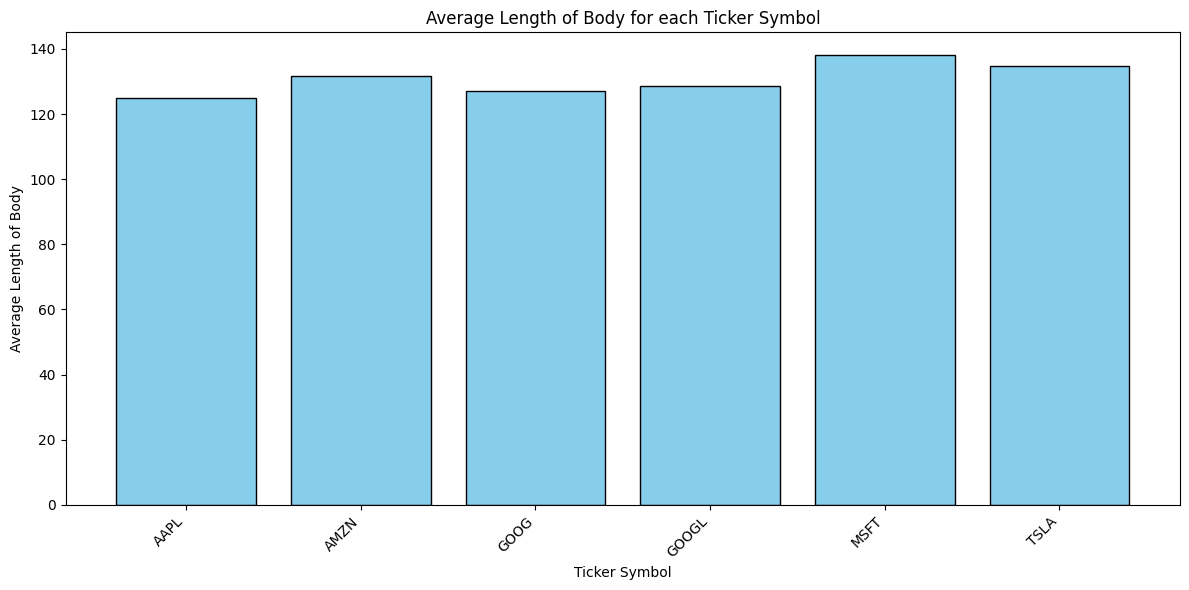

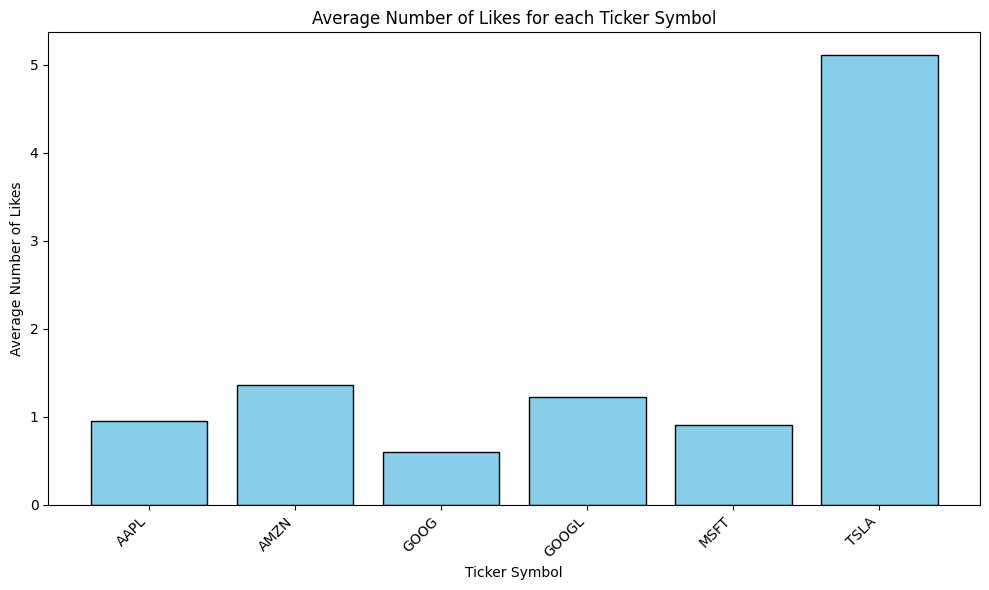

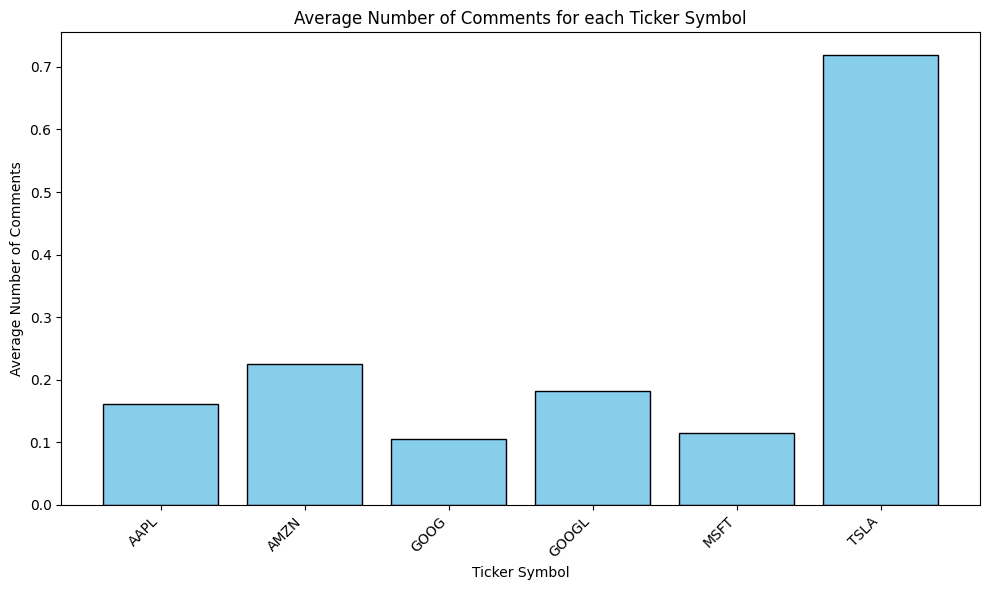

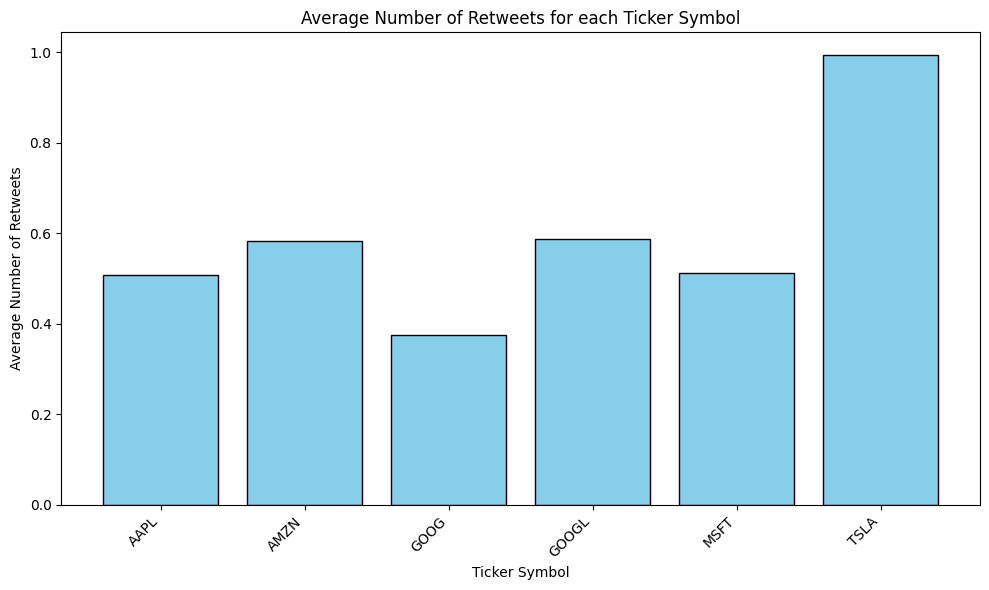

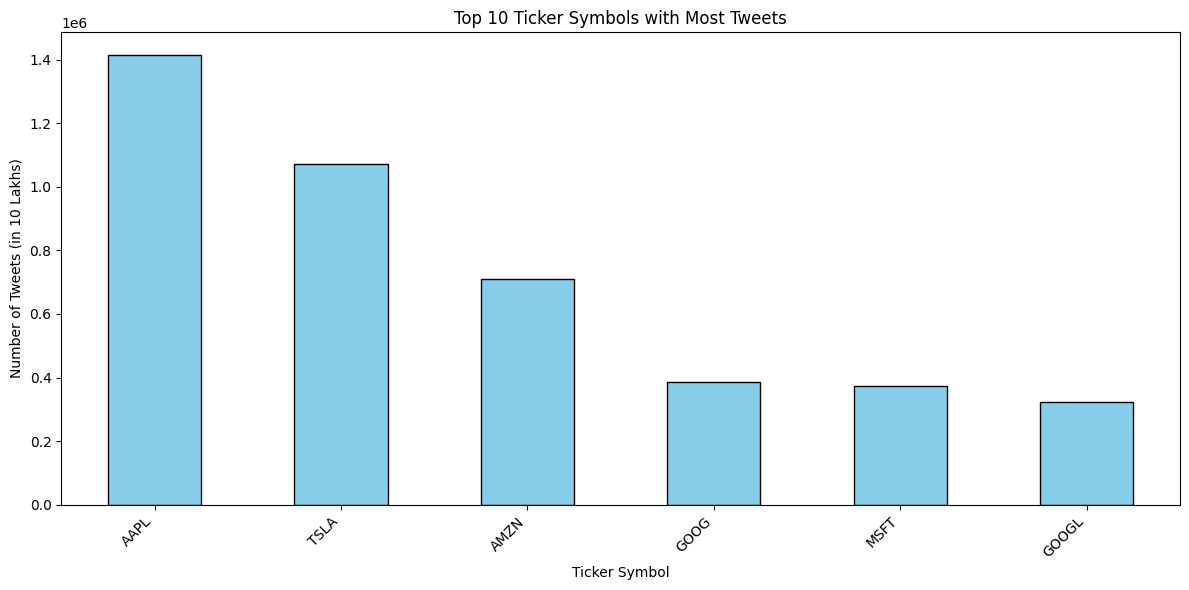

In [33]:
import matplotlib.pyplot as plt
import pandas as pd


# Calculate average length of body for each ticker_symbol
avg_length_df = tweets_dataset_pd.groupby('ticker_symbol')['body'].apply(lambda x: x.str.len().mean()).reset_index()
avg_length_df.columns = ['ticker_symbol', 'avg_body_length']

# Plot bar plot for ticker_symbol vs average length of body
plt.figure(figsize=(12, 6))
plt.bar(avg_length_df['ticker_symbol'], avg_length_df['avg_body_length'], color='skyblue', edgecolor='black')
plt.xlabel('Ticker Symbol')
plt.ylabel('Average Length of Body')
plt.title('Average Length of Body for each Ticker Symbol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate average no of likes for each ticker_symbol
avg_like_df = tweets_dataset_pd.groupby('ticker_symbol')['like_num_numeric'].apply(lambda x: x.mean()).reset_index()
avg_like_df.columns = ['ticker_symbol', 'avg_no_of_likes']

# Plot bar plot for ticker_symbol vs average length of body
plt.figure(figsize=(10, 6))
plt.bar(avg_like_df['ticker_symbol'], avg_like_df['avg_no_of_likes'], color='skyblue', edgecolor='black')
plt.xlabel('Ticker Symbol')
plt.ylabel('Average Number of Likes')
plt.title('Average Number of Likes for each Ticker Symbol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate average no of comments for each ticker_symbol
avg_cm_df = tweets_dataset_pd.groupby('ticker_symbol')['comment_num_numeric'].apply(lambda x: x.mean()).reset_index()
avg_cm_df.columns = ['ticker_symbol', 'avg_no_of_comments']

# Plot bar plot for ticker_symbol vs average length of body
plt.figure(figsize=(10, 6))
plt.bar(avg_cm_df['ticker_symbol'], avg_cm_df['avg_no_of_comments'], color='skyblue', edgecolor='black')
plt.xlabel('Ticker Symbol')
plt.ylabel('Average Number of Comments')
plt.title('Average Number of Comments for each Ticker Symbol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Calculate average no of comments for each ticker_symbol
avg_rt_df = tweets_dataset_pd.groupby('ticker_symbol')['retweet_num_numeric'].apply(lambda x: x.mean()).reset_index()
avg_rt_df.columns = ['ticker_symbol', 'avg_no_of_rts']

# Plot bar plot for ticker_symbol vs average length of body
plt.figure(figsize=(10, 6))
plt.bar(avg_rt_df['ticker_symbol'], avg_rt_df['avg_no_of_rts'], color='skyblue', edgecolor='black')
plt.xlabel('Ticker Symbol')
plt.ylabel('Average Number of Retweets')
plt.title('Average Number of Retweets for each Ticker Symbol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# Plot bar plot for top 10 ticker symbols with most tweets
top_ticker_symbols = tweets_dataset_pd['ticker_symbol'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
top_ticker_symbols.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Ticker Symbol')
plt.ylabel('Number of Tweets (in 10 Lakhs)')
plt.title('Top 10 Ticker Symbols with Most Tweets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


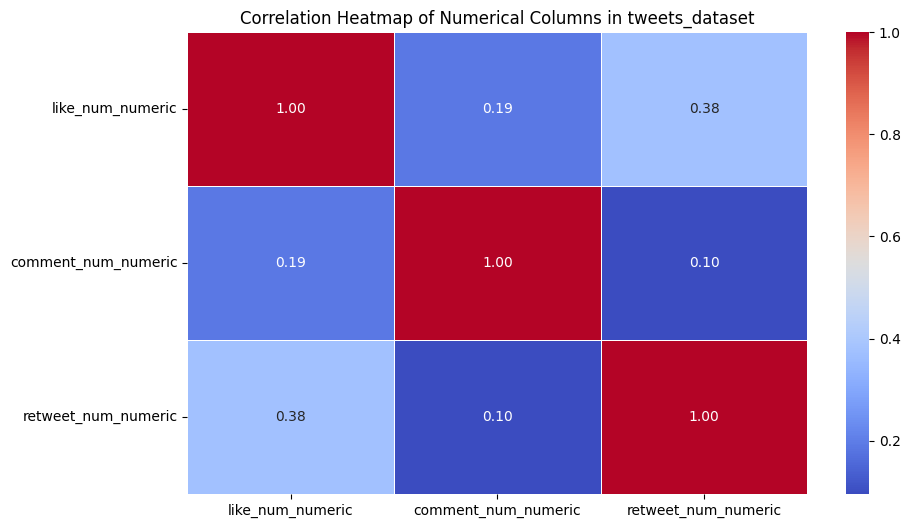

In [43]:
import seaborn as sns

# Select numerical columns from the DataFrame
numerical_columns = ['like_num_numeric', 'comment_num_numeric', 'retweet_num_numeric']

# Filter the DataFrame to include only numerical columns
numerical_df = tweets_dataset_pd[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Columns in tweets_dataset')
plt.show()


In [24]:
tweets_dataset_pd.head()

,tweet_id,writer,post_date,body,comment_num_numeric,retweet_num_numeric,like_num_numeric,ticker_symbol
0,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0.0,AMZN
1,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1.0,AAPL
2,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1.0,TSLA
3,550444970738335744,espositooooo,1420071282,“@WSJ: Apple is being sued for falsely adverti...,0,0,0.0,AAPL
4,550447850857828352,JorelLaraKalel,1420071969,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,0,0,2.0,AAPL


#### HiveQL querying

In [34]:
# Count of Distinct Writers
distinct_writers_count = spark.sql("""
SELECT COUNT(DISTINCT writer) AS distinct_writer_count
FROM tweets_dataset
""")
distinct_writers_count.show()

+---------------------+
|distinct_writer_count|
+---------------------+
|               140128|
+---------------------+



In [35]:
# Top 5 Writers with Most Number of Tweets
top_writers = spark.sql("""
SELECT writer, COUNT(*) AS tweet_count
FROM tweets_dataset
GROUP BY writer
ORDER BY tweet_count DESC
LIMIT 5
""")
top_writers.show()


+--------------+-----------+
|        writer|tweet_count|
+--------------+-----------+
|       App_sw_|      91740|
|  _peripherals|      91461|
|computer_hware|      90919|
| PortfolioBuzz|      87910|
| It_c0nsulting|      75270|
+--------------+-----------+



In [36]:
# Top 5 Liked Tweets
top_liked_tweets = spark.sql("""
SELECT tweet_id, writer, body, like_num_numeric
FROM tweets_dataset
ORDER BY like_num_numeric DESC
LIMIT 5
""")
top_liked_tweets.show(truncate=False)


+-------------------+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|tweet_id           |writer      |body                                                                                                                                                                                                                                                                   |like_num_numeric|
+-------------------+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+
|985661686874066946 |markbspiegel|"""This is gonna s

In [37]:
# Top 5 Retweeted Tweets
top_retweeted_tweets = spark.sql("""
SELECT tweet_id, writer, body, retweet_num_numeric
FROM tweets_dataset
ORDER BY retweet_num_numeric DESC
LIMIT 5
""")
top_retweeted_tweets.show(truncate=False)

+-------------------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|tweet_id           |writer        |body                                                                                                                                                                                                                |retweet_num_numeric|
+-------------------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|685205321443196928 |iSPYTrading   |$SPY 1-7-16 Full Day #TapeReading What a day.. $AAPL $VXX $GPRO                                                                                           

In [38]:
# Top 5 Commented Tweets
top_commented_tweets = spark.sql("""
SELECT tweet_id, writer, body, comment_num_numeric
FROM tweets_dataset
ORDER BY comment_num_numeric DESC
LIMIT 5
""")
top_commented_tweets.show(truncate=False)


+-------------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|tweet_id           |writer        |body                                                                                                                                                                                                                                                                                   |comment_num_numeric|
+-------------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------

In [39]:
# Convert post_date to Date Format for Any 5 Rows and Display
converted_dates = spark.sql("""
SELECT tweet_id, writer, body,
       from_unixtime(post_date) AS post_date_formatted
FROM tweets_dataset
LIMIT 5
""")
converted_dates.show(truncate=False)


+------------------+--------------+----------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|tweet_id          |writer        |body                                                                                                                                    |post_date_formatted|
+------------------+--------------+----------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|550441732014223360|DozenStocks   |S&P100 #Stocks Performance $HD $LOW $SBUX $TGT $DVN $IBM $AMZN $F $APA $GM $MS $HAL $DIS $MCD $BMY $XOM  more@ http://12Stocks.com/sp100|2015-01-01 00:01:50|
|550443807834402816|i_Know_First  |Swing Trading: Up To 8.91% Return In 14 Days http://ow.ly/GDks0 #swingtrading #forecast #techstock $MWW $AAPL $TSLA                     |2015-01-01 00:10:05|
|550443807834402816|i_Know_First  |

In [40]:
# Average Length of the Body Column Values
average_body_length = spark.sql("""
SELECT AVG(LENGTH(body)) AS average_body_length
FROM tweets_dataset
""")
average_body_length.show()


+-------------------+
|average_body_length|
+-------------------+
| 130.12279099150203|
+-------------------+



In [41]:
# The top writer for each ticker_symbol
hive_query = """
SELECT ticker_symbol, writer, tweet_count
FROM (
    SELECT ticker_symbol, writer, COUNT(*) AS tweet_count,
           RANK() OVER (PARTITION BY ticker_symbol ORDER BY COUNT(*) DESC) AS rank
    FROM tweets_dataset
    GROUP BY ticker_symbol, writer
) ranked
WHERE rank = 1
"""

# Execute the query
top_writers_df = spark.sql(hive_query)

# Show the results
top_writers_df.show()

+-------------+---------------+-----------+
|ticker_symbol|         writer|tweet_count|
+-------------+---------------+-----------+
|         AAPL|   _peripherals|      91424|
|         AMZN|     retail_Dbt|      44093|
|         GOOG|  It_c0nsulting|      75058|
|        GOOGL|ExactOptionPick|      18819|
|         MSFT|        App_sw_|      91639|
|         TSLA|   markbspiegel|      17953|
+-------------+---------------+-----------+



#### Beam Data Processing

In [24]:
#!pip install apache_beam
import apache_beam as beam
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


output_path = '/content/drive/MyDrive/Courses/Sem 2/Big data /tweets'

import apache_beam as beam
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize NLTK resources
stop_words = set(stopwords.words('english'))
sid = SentimentIntensityAnalyzer()

def tokenize_tweet(tweet):
    # Tokenize the tweet text and remove stop words
    tokens = [token.lower() for token in tweet.split() if token.lower() not in stop_words]
    return tokens

def label_sentiment(tweet):
    # Label the sentiment of each token using NLTK Vader
    sentiment_score = sid.polarity_scores(tweet)['compound']
    if sentiment_score > 0.05:
        return 'positive'
    elif sentiment_score < -0.05:
        return 'negative'
    else:
        return 'neutral'

with beam.Pipeline() as pipeline:
    # Read data from the tweets_dataset_pd DataFrame
    tweets = (
        pipeline
        | 'Read from source' >> beam.Create(tweets_dataset_pd['body'][:10].tolist())
        | 'Label sentiment' >> beam.Map(lambda tweet: (tweet, label_sentiment(tweet)))
        | 'Write to output' >> beam.io.WriteToText(output_path, file_name_suffix='.csv')
    )

# Read the output files into a PySpark DataFrame
output_df = spark.read.csv(output_path + '*.csv', header=False, inferSchema=True)
output_df = output_df.withColumnRenamed('_c0', 'body').withColumnRenamed('_c1', 'sentiment')  # Rename the columns

# Show the DataFrame
output_df.show()

+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+
|              body|      sentiment|       _c2|                 _c3|                _c4|                _c5|             _c6|          _c7|
+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+
|          tweet_id|         writer| post_date|                body|comment_num_numeric|retweet_num_numeric|like_num_numeric|ticker_symbol|
|550441732014223360|    DozenStocks|1420070510|S&P100 #Stocks Pe...|                  0|                  0|               0|         AMZN|
|550443807834402816|   i_Know_First|1420071005|Swing Trading: Up...|                  0|                  0|               1|         AAPL|
|550443807834402816|   i_Know_First|1420071005|Swing Trading: Up...|                  0|                  0|               1|         TSLA|
|550444970738335744|

#### PySpark

In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .config("spark.sql.warehouse.dir", "/user/hive/warehouse") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .enableHiveSupport() \
    .getOrCreate()

tweets_df = spark.sql("SELECT * FROM tweets_dataset")

# nltk.download('vader_lexicon')
# nltk.download('stopwords')

sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

remove_stopwords_udf = udf(remove_stopwords, StringType())

def analyze_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

analyze_sentiment_udf = udf(analyze_sentiment, StringType())


tweets_df_cleaned = tweets_df.withColumn("cleaned_body", remove_stopwords_udf(tweets_df['body']))
tweets_df_with_sentiment = tweets_df_cleaned.withColumn("sentiment", analyze_sentiment_udf(tweets_df_cleaned['cleaned_body']))


tweets_df_with_sentiment.show(5)



+-------+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+--------------------+---------+
|    _c0|          tweet_id|         writer| post_date|                body|comment_num_numeric|retweet_num_numeric|like_num_numeric|ticker_symbol|        cleaned_body|sentiment|
+-------+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+--------------------+---------+
|1409583|984481894309023745|askwarrenbuffet|1523553749|Truly beneficial ...|                  0|                  0|               0|         GOOG|Truly beneficial ...| positive|
|1409584|984481894309023745|askwarrenbuffet|1523553749|Truly beneficial ...|                  0|                  0|               0|         AMZN|Truly beneficial ...| positive|
|1409585|984481894309023745|askwarrenbuffet|1523553749|Truly beneficial ...|                  0|         

In [36]:

# Write the updated DataFrame to CSV
#output_path = 'final_data.csv'
#tweets_df_with_sentiment.toPandas().shape
#.to_csv(output_path, header=True)
tweets_df_with_sentiment.write.mode("overwrite").saveAsTable("tweets_sentiment")
#print(f"Data with sentiment column written to {output_path}")

#### Subsampling to 4L rows

In [ ]:
import nltk

nltk.download('vader_lexicon')
nltk.download('stopwords')
spark.sql("select count(*) from tweets_dataset").show()

+--------+
|count(1)|
+--------+
| 4280314|
+--------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .config("spark.sql.warehouse.dir", "/user/hive/warehouse") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .enableHiveSupport() \
    .getOrCreate()


df = spark.sql("SELECT * FROM tweets_dataset limit 400000 ")

nltk.download('vader_lexicon')
nltk.download('stopwords')


sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

remove_stopwords_udf = udf(remove_stopwords, StringType())

# Define a UDF to analyze sentiment
def analyze_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

analyze_sentiment_udf = udf(analyze_sentiment, StringType())

# Apply the UDFs to the DataFrame
df_cleaned = df.withColumn("cleaned_body", remove_stopwords_udf(df['body']))
df_with_sentiment = df_cleaned.withColumn("sentiment", analyze_sentiment_udf(df_cleaned['cleaned_body']))

In [ ]:
df_with_sentiment.toPandas().to_csv("/content/drive/MyDrive/Courses/Sem 2/Big data /dataset_4L.csv", header=True)

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
schema = StructType([
    StructField("_c0", IntegerType(), True),
    StructField("tweet_id", StringType(), True),
    StructField("writer", StringType(), True),
    StructField("post_date", StringType(), True),
    StructField("body", StringType(), True),
    StructField("comment_num_numeric", IntegerType(), True),
    StructField("retweet_num_numeric", IntegerType(), True),
    StructField("like_num_numeric", IntegerType(), True),
    StructField("ticker_symbol", StringType(), True),
    StructField("cleaned_body", StringType(), True),
    StructField("sentiment", StringType(), True)
])
df_with_sentiment = spark.read.csv("/content/drive/MyDrive/Courses/Sem 2/Big data /dataset_4L.csv", header=True, schema=schema)
df_with_sentiment = df_with_sentiment.sample(withReplacement=False, fraction=0.1, seed=42)
df_with_sentiment.head()

Row(_c0=7, tweet_id='984087464640905216', writer='OACtrading', post_date='1523459709', body='NOW OFFERING 7 Day FREE Trial to  options day trading team Room or $TWTR feed http://ow.ly/UnjD30jqogY$PCLN $AAPL $NFLX $TSLA $AMZN $GOOGL', comment_num_numeric=0, retweet_num_numeric=None, like_num_numeric=None, ticker_symbol='TSLA', cleaned_body='OFFERING 7 Day FREE Trial options day trading team Room $TWTR feed http://ow.ly/UnjD30jqogY$PCLN $AAPL $NFLX $TSLA $AMZN $GOOGL', sentiment='positive')

In [ ]:
df_with_sentiment.count()

39853

###  Sentiment Analysis

In [ ]:
data = spark.read.csv("/content/drive/MyDrive/Courses/Sem 2/Big data /dataset_4L.csv", header=True, schema=schema)
df = data
df.show(5)

+---+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+--------------------+---------+
|_c0|          tweet_id|         writer| post_date|                body|comment_num_numeric|retweet_num_numeric|like_num_numeric|ticker_symbol|        cleaned_body|sentiment|
+---+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+--------------------+---------+
|  0|984085642253668352|askwarrenbuffet|1523459275|Your success will...|                  0|               NULL|            NULL|         GOOG|success come quic...| positive|
|  1|984085642253668352|askwarrenbuffet|1523459275|Your success will...|                  0|               NULL|            NULL|         AMZN|success come quic...| positive|
|  2|984085642253668352|askwarrenbuffet|1523459275|Your success will...|                  0|               NULL|            N

In [ ]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="cleaned_body", outputCol="tokens")
df = tokenizer.transform(df)
df.select("tokens").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[success, come,

In [ ]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

df = remover.transform(df)
df.select("tokens", "filtered_tokens").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                                                                                                               |filtered_tokens    

In [ ]:
from pyspark.ml.feature import Word2Vec

word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="filtered_tokens", outputCol="word2vec_features")

model = word2Vec.fit(df)
df = model.transform(df)

df.select("filtered_tokens", "word2vec_features").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol="sentiment", outputCol="label")

string_indexer_model = string_indexer.fit(df)
df = string_indexer_model.transform(df)

df.select("sentiment", "label").show(5)


+---------+-----+
|Sentiment|label|
+---------+-----+
| positive|  1.0|
| positive|  1.0|
| positive|  1.0|
| positive|  1.0|
| positive|  1.0|
+---------+-----+
only showing top 5 rows



In [ ]:
df.show(5)
df.printSchema()

+---+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+--------------------+---------+--------------------+--------------------+--------------------+-----+
|_c0|          tweet_id|         writer| post_date|                body|comment_num_numeric|retweet_num_numeric|like_num_numeric|ticker_symbol|        cleaned_body|sentiment|              tokens|     filtered_tokens|   word2vec_features|label|
+---+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+--------------------+---------+--------------------+--------------------+--------------------+-----+
|  0|984085642253668352|askwarrenbuffet|1523459275|Your success will...|                  0|               NULL|            NULL|         GOOG|success come quic...| positive|[success, come, q...|[success, come, q...|[0.16009340091113...|  1.0|
|  1|984085642253668352|

In [ ]:
# set seed for reproducibility
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 279834
Test Dataset Count: 120166


In [5]:
#!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Start Spark session
spark = SparkSession.builder.appName("SentimentFrequency").getOrCreate()

# Load the dataset with header and schema inference
file_path = "/content/drive/MyDrive/Courses/Sem 2/Big data /dataset_4L.csv"  # Replace with the actual path to your file
df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# Show the schema and the first few rows
df.printSchema()
df.show(5)

# Calculate the frequency of each class in the 'sentiment' column
class_frequency = df.groupBy("sentiment").count().orderBy("count", ascending=False)
class_frequency.show()

# Stop the Spark session
spark.stop()


root
 |-- _c0: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- writer: string (nullable = true)
 |-- post_date: integer (nullable = true)
 |-- body: string (nullable = true)
 |-- comment_num_numeric: string (nullable = true)
 |-- retweet_num_numeric: string (nullable = true)
 |-- like_num_numeric: string (nullable = true)
 |-- ticker_symbol: string (nullable = true)
 |-- cleaned_body: string (nullable = true)
 |-- sentiment: string (nullable = true)

+---+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+--------------------+---------+
|_c0|          tweet_id|         writer| post_date|                body|comment_num_numeric|retweet_num_numeric|like_num_numeric|ticker_symbol|        cleaned_body|sentiment|
+---+------------------+---------------+----------+--------------------+-------------------+-------------------+----------------+-------------+--------------------+---------+

#### Logistic Regression

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Split the data into train and test sets
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=100)

# Initialize Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="word2vec_features")

# Fit Logistic Regression model to the training dataset
model = lr.fit(trainingData)

# Make predictions on the test dataset
predictions = model.transform(testData)

# Evaluate the model performance using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Convert DataFrame to RDD for using MulticlassMetrics
prediction_and_label = predictions.select("prediction", "label").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(prediction_and_label)

labels = [0.0, 1.0, 2.0]

# Overall statistics
print("\nSummary Stats")
for label in labels:
    print("Precision for {} = {:.2f}".format(label, metrics.precision(label)))
    print("Recall for {} = {:.2f}".format(label, metrics.recall(label)))
    print("F1 Score for {} = {:.2f}".format(label, metrics.fMeasure(label)))

# Accuracy
print("LogisticRegression Accuracy = {:.2f}".format(metrics.accuracy))

# Confusion matrix
print("\nConfusion Matrix")
print(metrics.confusionMatrix().toArray())

# Calculate precision, recall, and F1-score for each class
class_metrics = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support for each class
    support = testData.filter(testData.label == label).count()

    class_metrics.append((label, precision, recall, f1_score, support))

# Print classification report
print("\n{:>10} {:>10} {:>10} {:>10} {:>10}".format("Class", "Precision", "Recall", "F1-score", "Support"))
for label, precision, recall, f1_score, support in class_metrics:
    print("{:>10} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.0f}".format(label, precision, recall, f1_score, support))


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Summary Stats
Precision for 0.0 = 0.64
Recall for 0.0 = 0.76
F1 Score for 0.0 = 0.69
Precision for 1.0 = 0.60
Recall for 1.0 = 0.63
F1 Score for 1.0 = 0.61
Precision for 2.0 = 0.43
Recall for 2.0 = 0.15
F1 Score for 2.0 = 0.22
LogisticRegression Accuracy = 0.61

Confusion Matrix
[[27426.  7574.  1242.]
 [10116. 19527.  1296.]
 [ 5584.  5619.  1951.]]

     Class  Precision     Recall   F1-score    Support
       0.0       0.64       0.76       0.69      36242
       1.0       0.60       0.63       0.61      30939
       2.0       0.43       0.15       0.22      13154


#### Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Split the data into train and test sets
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=100)

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="word2vec_features")

# Fit Decision Tree classifier to the training dataset
model = dt.fit(trainingData)

# Make predictions on the test dataset
predictions = model.transform(testData)

# Evaluate the model performance using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Convert DataFrame to RDD for using MulticlassMetrics
prediction_and_label = predictions.select("prediction", "label").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(prediction_and_label)

labels = [0.0, 1.0, 2.0]  # Update the labels based on your dataset

# Overall statistics
print("\nSummary Stats")
for label in labels:
    print("Precision for {} = {:.2f}".format(label, metrics.precision(label)))
    print("Recall for {} = {:.2f}".format(label, metrics.recall(label)))
    print("F1 Score for {} = {:.2f}".format(label, metrics.fMeasure(label)))

# Accuracy
print("Decision Tree Accuracy = {:.2f}".format(metrics.accuracy))

# Confusion matrix
print("\nConfusion Matrix")
print(metrics.confusionMatrix().toArray())

# Calculate precision, recall, and F1-score for each class
class_metrics = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support for each class
    support = testData.filter(testData.label == label).count()

    class_metrics.append((label, precision, recall, f1_score, support))

# Print classification report
print("\n{:>10} {:>10} {:>10} {:>10} {:>10}".format("Class", "Precision", "Recall", "F1-score", "Support"))
for label, precision, recall, f1_score, support in class_metrics:
    print("{:>10} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.0f}".format(label, precision, recall, f1_score, support))



Summary Stats
Precision for 0.0 = 0.56
Recall for 0.0 = 0.82
F1 Score for 0.0 = 0.67
Precision for 1.0 = 0.56
Recall for 1.0 = 0.49
F1 Score for 1.0 = 0.52
Precision for 2.0 = 0.57
Recall for 2.0 = 0.00
F1 Score for 2.0 = 0.00
Decision Tree Accuracy = 0.56

Confusion Matrix
[[4.4395e+04 1.0037e+04 1.5000e+01]
 [2.3308e+04 2.2812e+04 3.0000e+00]
 [1.1353e+04 8.2190e+03 2.4000e+01]]

     Class  Precision     Recall   F1-score    Support
       0.0       0.56       0.82       0.67      54447
       1.0       0.56       0.49       0.52      46123
       2.0       0.57       0.00       0.00      19596


#### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Split the data into train and test sets
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=100)

# Initialize Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="word2vec_features", numTrees=10)

# Fit Random Forest classifier to the training dataset
model = rf.fit(trainingData)

# Make predictions on the test dataset
predictions = model.transform(testData)

# Evaluate the model performance using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Convert DataFrame to RDD for using MulticlassMetrics
prediction_and_label = predictions.select("prediction", "label").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(prediction_and_label)

labels = [0.0, 1.0, 2.0]  # Update the labels based on your dataset

# Overall statistics
print("\nSummary Stats")
for label in labels:
    print("Precision for {} = {:.2f}".format(label, metrics.precision(label)))
    print("Recall for {} = {:.2f}".format(label, metrics.recall(label)))
    print("F1 Score for {} = {:.2f}".format(label, metrics.fMeasure(label)))

# Accuracy
print("\nRandom Forest Accuracy = {:.2f}".format(metrics.accuracy))

# Confusion matrix
print("\nConfusion Matrix")
print(metrics.confusionMatrix().toArray())

# Calculate precision, recall, and F1-score for each class
class_metrics = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support for each class
    support = testData.filter(testData.label == label).count()

    class_metrics.append((label, precision, recall, f1_score, support))

# Print classification report
print("\n{:>10} {:>10} {:>10} {:>10} {:>10}".format("Class", "Precision", "Recall", "F1-score", "Support"))
for label, precision, recall, f1_score, support in class_metrics:
    print("{:>10} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.0f}".format(label, precision, recall, f1_score, support))



Summary Stats
Precision for 0.0 = 0.58
Recall for 0.0 = 0.81
F1 Score for 0.0 = 0.68
Precision for 1.0 = 0.56
Recall for 1.0 = 0.54
F1 Score for 1.0 = 0.55
Precision for 2.0 = 1.00
Recall for 2.0 = 0.00
F1 Score for 2.0 = 0.00

Random Forest Accuracy = 0.57

Confusion Matrix
[[29413.  6829.     0.]
 [14209. 16730.     0.]
 [ 6715.  6407.    32.]]

     Class  Precision     Recall   F1-score    Support
       0.0       0.58       0.81       0.68      36242
       1.0       0.56       0.54       0.55      30939
       2.0       1.00       0.00       0.00      13154


#### Multilayer Perceptron Classifier

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into train and test sets
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=100)

input_size = len(trainingData.select("word2vec_features").first()[0])
output_size = trainingData.select("label").distinct().count()

# Define the layers of the neural network
# Example: [input_size, 64, 32, output_size] means input layer of size input_size,
# one hidden layer of size 64, another hidden layer of size 32, and output layer of size output_size
layers = [input_size, 64, 32, output_size]

# Initialize MultilayerPerceptronClassifier
mlpc = MultilayerPerceptronClassifier(layers=layers, seed=100, labelCol="label", featuresCol="word2vec_features")

# Fit MultilayerPerceptronClassifier to the training dataset
model = mlpc.fit(trainingData)

# Make predictions on the test dataset
predictions = model.transform(testData)

# Evaluate the model performance using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("MLPC Accuracy:", accuracy)

# Convert DataFrame to RDD for using MulticlassMetrics
prediction_and_label = predictions.select("prediction", "label").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(prediction_and_label)

# Overall statistics
print("\nSummary Stats")
for label in labels:
    print("Precision for {} = {:.2f}".format(label, metrics.precision(label)))
    print("Recall for {} = {:.2f}".format(label, metrics.recall(label)))
    print("F1 Score for {} = {:.2f}".format(label, metrics.fMeasure(label)))

# Accuracy
print("\nMLPC Accuracy:", metrics.accuracy)

# Confusion matrix
print("\nConfusion Matrix")
print(metrics.confusionMatrix().toArray())

# Calculate precision, recall, and F1-score for each class
class_metrics = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support for each class
    support = testData.filter(testData.label == label).count()

    class_metrics.append((label, precision, recall, f1_score, support))

# Print classification report
print("\n{:>10} {:>10} {:>10} {:>10} {:>10}".format("Class", "Precision", "Recall", "F1-score", "Support"))
for label, precision, recall, f1_score, support in class_metrics:
    print("{:>10} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.0f}".format(label, precision, recall, f1_score, support))

MLPC Accuracy: 0.6074687247152548


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Summary Stats
Precision for 0.0 = 0.64
Recall for 0.0 = 0.75
F1 Score for 0.0 = 0.69
Precision for 1.0 = 0.59
Recall for 1.0 = 0.63
F1 Score for 1.0 = 0.61
Precision for 2.0 = 0.43
Recall for 2.0 = 0.15
F1 Score for 2.0 = 0.23

MLPC Accuracy: 0.6074687247152548

Confusion Matrix
[[27226.  7788.  1228.]
 [ 9941. 19547.  1451.]
 [ 5527.  5599.  2028.]]

     Class  Precision     Recall   F1-score    Support
       0.0       0.64       0.75       0.69      36242
       1.0       0.59       0.63       0.61      30939
       2.0       0.43       0.15       0.23      13154


#### LR with Cross Validation

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics

# Split the data into train and test sets
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=100)

# Initialize Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="word2vec_features")

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2])
             .build())

# Initialize CrossValidator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Fit CrossValidator to the training dataset
cvModel = crossval.fit(trainingData)

# Make predictions on the test dataset
predictions = cvModel.transform(testData)

# Evaluate the model performance using MulticlassClassificationEvaluator
accuracy = evaluator.evaluate(predictions)

# Convert DataFrame to RDD for using MulticlassMetrics
prediction_and_label = predictions.select("prediction", "label").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(prediction_and_label)

labels = [0.0, 1.0, 2.0]

# Overall statistics
print("\nSummary Stats")
for label in labels:
    print("Precision for {} = {:.2f}".format(label, metrics.precision(label)))
    print("Recall for {} = {:.2f}".format(label, metrics.recall(label)))
    print("F1 Score for {} = {:.2f}".format(label, metrics.fMeasure(label)))

# Accuracy
print("LogisticRegression Accuracy = {:.2f}".format(metrics.accuracy))

# Confusion matrix
print("\nConfusion Matrix")
print(metrics.confusionMatrix().toArray())

# Calculate precision, recall, and F1-score for each class
class_metrics = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    # Calculate support for each class
    support = testData.filter(testData.label == label).count()

    class_metrics.append((label, precision, recall, f1_score, support))

# Print classification report
print("\n{:>10} {:>10} {:>10} {:>10} {:>10}".format("Class", "Precision", "Recall", "F1-score", "Support"))
for label, precision, recall, f1_score, support in class_metrics:
    print("{:>10} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.0f}".format(label, precision, recall, f1_score, support))



Summary Stats
Precision for 0.0 = 0.62
Recall for 0.0 = 0.78
F1 Score for 0.0 = 0.69
Precision for 1.0 = 0.58
Recall for 1.0 = 0.63
F1 Score for 1.0 = 0.60
Precision for 2.0 = 0.46
Recall for 2.0 = 0.05
F1 Score for 2.0 = 0.09
LogisticRegression Accuracy = 0.60

Confusion Matrix
[[28100.  7753.   389.]
 [11098. 19422.   419.]
 [ 6128.  6330.   696.]]

     Class  Precision     Recall   F1-score    Support
       0.0       0.62       0.78       0.69      36242
       1.0       0.58       0.63       0.60      30939
       2.0       0.46       0.05       0.09      13154
